# Phones and Shoes

* CPM CellPhoneMeadows (250 bp)
> [*Mobile phones carry the personal microbiome of their owners*](https://peerj.com/articles/447/), James F. Meadow, Adam E. Altrichter, Jessica L. Green, **PeerJ**
* SPM SPaceMicrobes (150 bp)
> [*A microbial survey of the International Space Station (ISS)*](https://peerj.com/articles/4029/), Jenna M. Lang, David A. Coil1, Russell Y. Neches, Wendy E. Brown, Darlene Cavalier, Mark Severance, Jarrad T. Hampton-Marcell, Jack A. Gilbert, Jonathan A. Eisen, **PeerJ**
* CPJ CellPhoneJack (150 bp)
> [*Forensic analysis of the microbiome of phones and shoes*](https://microbiomejournal.biomedcentral.com/articles/10.1186/s40168-015-0082-9), Simon Lax, Jarrad T Hampton-Marcell, Sean M Gibbons, Geórgia Barguil Colares, Daniel Smith, Jonathan A Eisen and Jack A Gilbert, **BMC Microbiome**
* CPR CellPhoneRussell (150 bp)

In [2]:
import pandas as pd
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

def RDStoDF( rds_path ) :

    readRDS = robjects.r['readRDS']

    table = readRDS( rds_path )
    colnames = list(table.colnames)
    rownames = list(table.rownames)
    
    return pd.DataFrame( pandas2ri.ri2py(table).reshape( table.dim, order='F' ),
                         index=rownames, columns=colnames )

In [3]:
taxtab = RDStoDF( 'data/dada2/tax_CPR_CPM_CPJ_SPM.rds' )

OTUs = pd.DataFrame( zip( taxtab.index, range(len(taxtab.index)) ), columns=['OTUseq','OTU'] ).set_index('OTUseq')

taxtab = taxtab.join(OTUs).set_index('OTU')
taxtab.head()

,Kingdom,Phylum,Class,Order,Family,Genus
OTU,,,,,,
0,Bacteria,Cyanobacteria,Chloroplast,NA,NA,NA
1,Bacteria,Tenericutes,Mollicutes,Mycoplasmatales,Mycoplasmataceae,Mycoplasma
2,Bacteria,Cyanobacteria,Chloroplast,NA,NA,NA
3,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus
4,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus


### Build multiple sequence alignment and tree

In [15]:
# write sequences as a FASTA file
# 
# DADA2 uses the actual sequences as sequence identifiers, which
# breaks clustalo (it truncates names to 128 characters). So, we
# have to give them temporary names.
with open( 'sequences.fasta', 'w' ) as f :
    for s,n in OTUs.iterrows() :
        f.write( '>' + 'otu_' + str(n.OTU) + '\n' + s + '\n' )

In [ ]:
!clustalo -l sequences.aln.log -o sequences.aln.fasta -i sequences.fasta

In [ ]:
!fasttreeMP -nt -gtr -gamma -log sequences.log sequences.aln.fasta > sequences.tree

In [ ]:
import pyprind

progbar = pyprind.ProgBar( len(OTUs), monitor=True )

treestring = open('sequences.tree').read()

for n,row in OTUs.iterrows() :
    progbar.update()
    otuname = 'otu_' + str(row.OTU) + ':'
    treestring = treestring.replace(otuname,row.name + ':')
    
with open( 'sequences.seqnames.tree', 'w' ) as f :
    f.write( treestring )

0% [############################  ] 100% | ETA: 00:03:45

In [5]:
seqtab = RDStoDF( 'data/dada2/seqtab_CPR_CPM_CPJ_SPM.rds' )

seqtab = seqtab.T.join(OTUs).set_index('OTU')\
               .rename_axis(None, axis=0, inplace=True)\
               .T.rename_axis('sample', axis=0, inplace=True)

seqtab.head()

,0,1,2,3,4,5,6,7,8,9,...,227619,227620,227621,227622,227623,227624,227625,227626,227627,227628
sample,,,,,,,,,,,,,,,,,,,,,
CPR_CP.AB025,901,0,427,909,1641,0,0,69,71,23,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB069,0,0,0,1335,4046,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB081,210,0,0,52,686,0,0,0,8,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB082,0,0,106,25,87,0,0,0,67,0,...,0,0,0,0,0,0,0,0,0,0
CPR_CP.AB083,0,0,0,136,279,0,0,338,0,0,...,0,0,0,0,0,0,0,0,0,0


### Import CPR metadata

In [4]:
cpr_metadata = pd.read_csv( 'data/qiime/shoephone_mapping.tsv', sep='\t', index_col=0 )
cpr_metadata.index = [ 'CPR_' + name for name in cpr_metadata.index ]

cpr_metadata['Study'] = 'cpr'

cpr_metadata.head()

,Sample,Event,Sport,Age,Date,City,State,Run,Type,Study
CPR_CP.MC013,MC013,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr
CPR_SH.MC047,MC047,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,shoe,cpr
CPR_CP.MC042,MC042,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr
CPR_CP.ME007,ME007,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr
CPR_CP.MC019,MC019,76ers,Basketball,Adult,2/18/2014,Philadelphia,PA,3,phone,cpr


### Import and reconsile CPM metadata

In [5]:
cpm_metadata = pd.read_csv( 'data/jfmeadow/phones_map.txt', sep='\t', index_col=0 )

# NOTE : I can't figure out what Meadow's 'type' column is supposed to represent

# drop unused metadata
cpm_metadata = cpm_metadata.drop( axis=1, labels=['BarcodeSequence',
                                                  'LinkerPrimerSequence',
                                                  'barcode',
                                                  'Description',
                                                  'type'])

# reconsile metadata names
cpm_metadata.columns = [ 'Sample', 'Type', 'Hand', 'Gender', 'Wash' ]
cpm_metadata['Sample'] = [ 'JM' + name for name in cpm_metadata['Sample'] ]

# reconsile rowids from DADA2
cpm_metadata.index = [ 'CPM_' + name + '.150.1.fq' for name in cpm_metadata.index ]

# fix up the controls
cpm_controls = cpm_metadata.filter( regex='cont', axis=0 )
cpm_controls['Sample'] = [ 'JMC' + str(x) for x in range(1,6) ]
cpm_controls['Type'] = 'control'
cpm_controls['Hand'] = None
cpm_controls['Gender'] = None
cpm_controls['Wash'] = None
cpm_metadata.update( cpm_controls )

# add collection location and date/time, age and event
cpm_metadata['State'] = 'NJ'
cpm_metadata['City'] = 'Princeton'
cpm_metadata['Date'] = '5/21/2013'
cpm_metadata['Age'] = 'Adult'
cpm_metadata['Event'] = 'Workshop'
cpm_metadata['Study'] = 'cpm'

cpm_metadata.head()

,Sample,Type,Hand,Gender,Wash,State,City,Date,Age,Event,Study
CPM_17.index.150.1.fq,JM17,index,r,f,n,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_17.phone.150.1.fq,JM17,phone,r,f,n,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_17.thumb.150.1.fq,JM17,thumb,r,f,n,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_18.index.150.1.fq,JM18,index,r,m,y,NJ,Princeton,5/21/2013,Adult,Workshop,cpm
CPM_18.phone.150.1.fq,JM18,phone,r,m,y,NJ,Princeton,5/21/2013,Adult,Workshop,cpm


### Import and reconsile CPJ metadata

In [6]:
cpj_metadata = pd.read_csv( 'data/slax/mapping_file.txt', sep='\t', index_col=0 )

# reconsile metadata column names
cpj_metadata['Type'] = cpj_metadata['Surface_2']

# drop unused metadata
cpj_metadata.drop( axis=1, inplace=True, labels=['BarcodeSequence',
                                                 'LinkerPrimerSequence',
                                                 'Description',
                                                 'Surface_Person',
                                                 'Surface_Person_Time',
                                                 'Person.Env.Time',
                                                 'Position',
                                                 'Surface_2'])

# drop unused barcodes
cpj_metadata.dropna( inplace=True )

# reconsile rowids from DADA2
cpj_metadata.index = [ 'CPJ_' + str(int(name)) for name in cpj_metadata.index ]

# reconsile metadata names
cpj_metadata['PersonID'] = map( int, cpj_metadata['PersonID'] )
cpj_metadata['Sample'] = [ 'SL' + str(name) for name in cpj_metadata['PersonID'] ]
cpj_metadata.drop('PersonID', axis=1, inplace=True)
cpj_metadata['Time'] = map( int, cpj_metadata['Time'] )

# add collection location and date/time, age and event
cpj_metadata['State'] = 'IL'
cpj_metadata['City'] = 'Chicago'
cpj_metadata['Date'] = '1/23/2015'
cpj_metadata['Age'] = 'Adult'
cpj_metadata['Event'] = 'Lab'
cpj_metadata['Study'] = 'cpj'

cpj_metadata.head()

,Surface,Time,Type,Sample,State,City,Date,Age,Event,Study
CPJ_214,right_shoe_tip,1,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_228,right_shoe_tip,3,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_235,right_shoe_tip,4,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_249,right_shoe_tip,6,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj
CPJ_256,right_shoe_tip,7,shoe,SL2,IL,Chicago,1/23/2015,Adult,Lab,cpj


### Import and reconsile SPM metadata

In [7]:
spm_metadata = pd.read_csv( 'data/jlang/ISS.txt', sep='\t', index_col=0 )

# drop rows from other projects
spm_metadata = spm_metadata[ spm_metadata.Description == 'ISS' ]

# Drop unused metadata
spm_metadata.drop( ['Description', 'Stuff', 'Gender', 'State', 'Age' ], axis=1, inplace=True )

# The column names are messed up, so rename them
spm_metadata.columns = [ 'Module', 'Surface', 'Touches' ]

# reconsile rowids from DADA2
spm_metadata.index = [ 'SPM_' + name + '_filt.fq.gz' for name in spm_metadata.index ]

# add collection location and date/time, age and event
spm_metadata['State'] = 'Low Earth Orbit'
spm_metadata['City'] = 'International Space Station'
spm_metadata['Date'] = '4/21/2014'
spm_metadata['Age'] = 'Adult'
spm_metadata['Event'] = 'Space Microbes'
spm_metadata['Study'] = 'spm'

spm_metadata.head()

,Module,Surface,Touches,State,City,Date,Age,Event,Study
SPM_SP13_filt.fq.gz,lab,keyboard,hand,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP14_filt.fq.gz,lab,handrail,hand,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP3_filt.fq.gz,lab,mic,hand/mouth,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP7_filt.fq.gz,lab,vent,dust,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm
SPM_SP1_filt.fq.gz,lab,mic,hand/mouth,Low Earth Orbit,International Space Station,4/21/2014,Adult,Space Microbes,spm


### Merge metadata

In [8]:
metadata = cpr_metadata.append( cpj_metadata ).append( cpm_metadata ).append( spm_metadata )

metadata.head()

,Age,City,Date,Event,Gender,Hand,Module,Run,Sample,Sport,State,Study,Surface,Time,Touches,Type,Wash
CPR_CP.MC013,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC013,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN
CPR_SH.MC047,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC047,Basketball,PA,cpr,NaN,NaN,NaN,shoe,NaN
CPR_CP.MC042,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC042,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN
CPR_CP.ME007,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,ME007,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN
CPR_CP.MC019,Adult,Philadelphia,2/18/2014,76ers,NaN,NaN,NaN,3.0,MC019,Basketball,PA,cpr,NaN,NaN,NaN,phone,NaN


### Drop metadata for failed samples in CPR dataset

In [13]:
failed = list( set( cpr_metadata.index ) - set( filter( lambda x : x.startswith( 'CPR_' ), seqtab.index ) ) )

metadata.drop(failed, inplace=True)

print 'dropped', len(failed), 'samples'

dropped 252 samples


In [14]:
set(seqtab.index) - set(metadata.index)

set()

In [15]:
metadata.to_csv( 'all_metadata.tsv', sep='\t' )

### Load data into phyloseq

In [15]:
%load_ext rpy2.ipython

In [16]:
%%R

library(phyloseq); packageVersion("phyloseq")
library(ggplot2); packageVersion("ggplot2")
library(dada2)
library(ape)

/home/russell/opt/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)


In [20]:
%%R

seqtree <- read.tree( "sequences.seqnames.tree" )
seqtab <- readRDS( "data/dada2/seqtab_CPR_CPM_CPJ_SPM.rds" )
taxtab <- readRDS( "data/dada2/tax_CPR_CPM_CPJ_SPM.rds" )
metadata <- read.csv( "all_metadata.tsv", sep="\t", row.names=1 )

In [21]:
%%R

ps <- phyloseq(otu_table(seqtab, taxa_are_rows=FALSE), 
               sample_data(metadata), 
               tax_table(taxtab),
               seqtree)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 227629 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 227629 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 227629 tips and 227627 internal nodes ]


From here, we are loosely following the workflow described in

> [*Bioconductor workflow for microbiome data analysis: from raw reads to community analyses*](https://f1000research.com/articles/5-1492/v2
), Ben J. Callahan, Kris Sankaran, Julia A. Fukuyama, Paul J. McMurdie, Susan P. Holmes, **F1000**

with some diversions. Notably, we directly call [`clustal omega`](http://www.clustal.org/omega/) to
make the multiple sequence alignment and [`FastTreeMP`](http://www.microbesonline.org/fasttree/) to
build the phylogenetic tree (see above), rather than working through R as suggested in Callahan *et al.*

In [22]:
%%R

# Define prevalence of each taxa
# (in how many samples did each taxa appear at least once)
prev0 = apply(X = otu_table(ps),
    MARGIN = ifelse(taxa_are_rows(ps), yes = 1, no = 2),
    FUN = function(x){sum(x > 0)})

prevdf = data.frame(Prevalence = prev0,
                      TotalAbundance = taxa_sums(ps),
                      tax_table(ps))

keepPhyla = table(prevdf$Phylum)[(table(prevdf$Phylum) > 5)]

prevdf1 = subset(prevdf, Phylum %in% names(keepPhyla))

# Define prevalence threshold as 5% of total samples
prevalenceThreshold = 0.05 * nsamples(ps)
prevalenceThreshold

[1] 133.65


In [23]:
%%R

# Execute prevalence filter, using `prune_taxa()` function
ps1 = prune_taxa((prev0 > prevalenceThreshold), ps)
ps1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2182 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 2182 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2182 tips and 2181 internal nodes ]


In [24]:
%%R

# Filter entries with unidentified Phylum.
ps2 = subset_taxa(ps1, Phylum %in% names(keepPhyla))
ps2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2147 taxa and 2673 samples ]
sample_data() Sample Data:       [ 2673 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 2147 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2147 tips and 2146 internal nodes ]


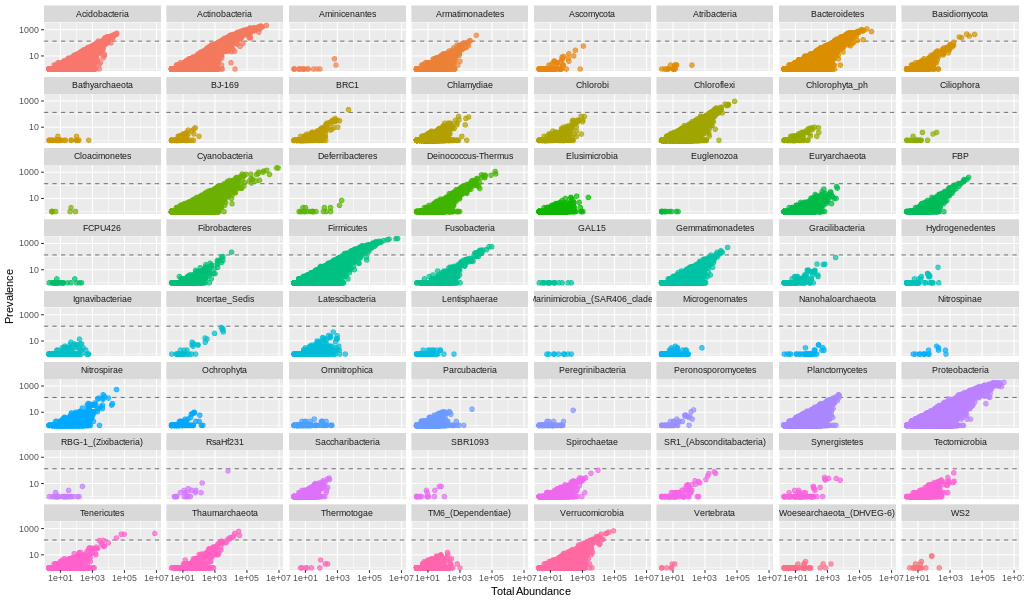

In [34]:
%%R -w 1024 -h 600 -u px

ggplot(prevdf1, aes(TotalAbundance, Prevalence, color = Phylum)) +
  geom_hline(yintercept = prevalenceThreshold, alpha = 0.5, linetype = 2) +
  geom_point(size = 2, alpha = 0.7) +
  scale_y_log10() + scale_x_log10() +
  xlab("Total Abundance") +
  facet_wrap(~Phylum) +
  theme(legend.position="none")

In [26]:
%%R

## ---- glom ----
# Taxonomic agglomeration
# How many genera are present after filtering?
taxGlomRank = "Genus"
length(get_taxa_unique(ps2, taxonomic.rank = taxGlomRank))

ps3 = tax_glom(ps2, taxrank = taxGlomRank)
# Phylogenetic agglomeration
# How many genera are present after filtering?
h1 = 0.4
ps4 = tip_glom(ps2, h = h1)

In [31]:
%%R

plot_abundance = function(physeq, ylabn = "",
                            Facet = "Order",
                            Color = "Phylum"){
    mphyseq = psmelt(physeq)
    mphyseq <- subset(mphyseq, Abundance > 0)
    ggplot( data = mphyseq,
            mapping = aes_string(x = "Type", y = "Abundance",
                                 color = Color, fill = Color)) +
    geom_violin(fill = NA) +
    geom_point( size = 1, alpha = 0.3,
                position = position_jitter(width = 0.3)) +
    facet_wrap(facets = Facet) + ylab(ylabn) +
    scale_y_log10()
}

# Transform to relative abundance. Save as new object.
ps3ra = transform_sample_counts(ps3, function(x){x / sum(x)})

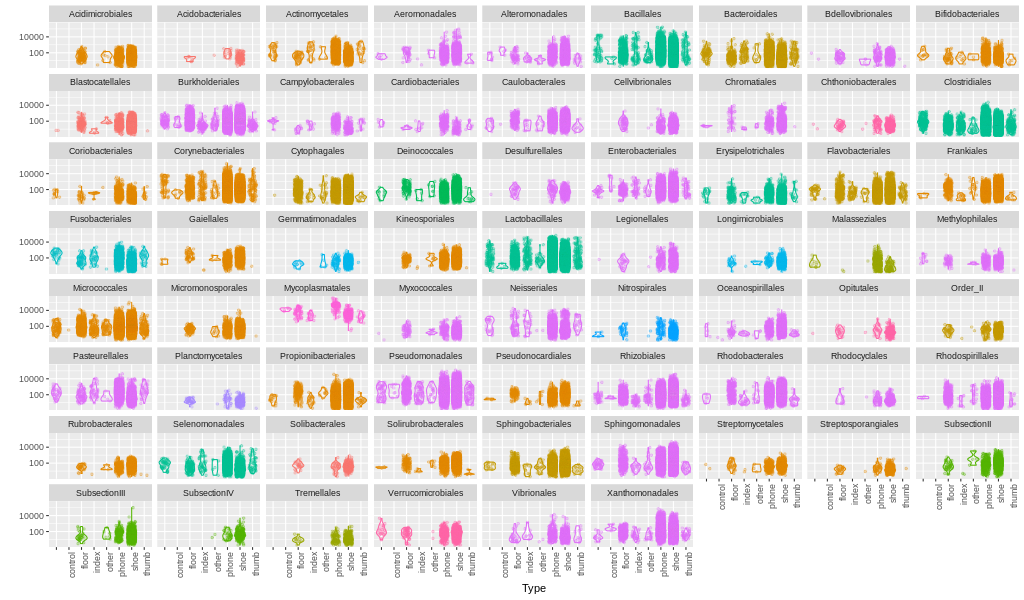

In [38]:
%%R -w 1024 -h 600 -u px

plot_abundance( ps3, "" ) +
    theme( legend.position="none",
           axis.text.x = element_text(angle = 90, hjust = 1) )

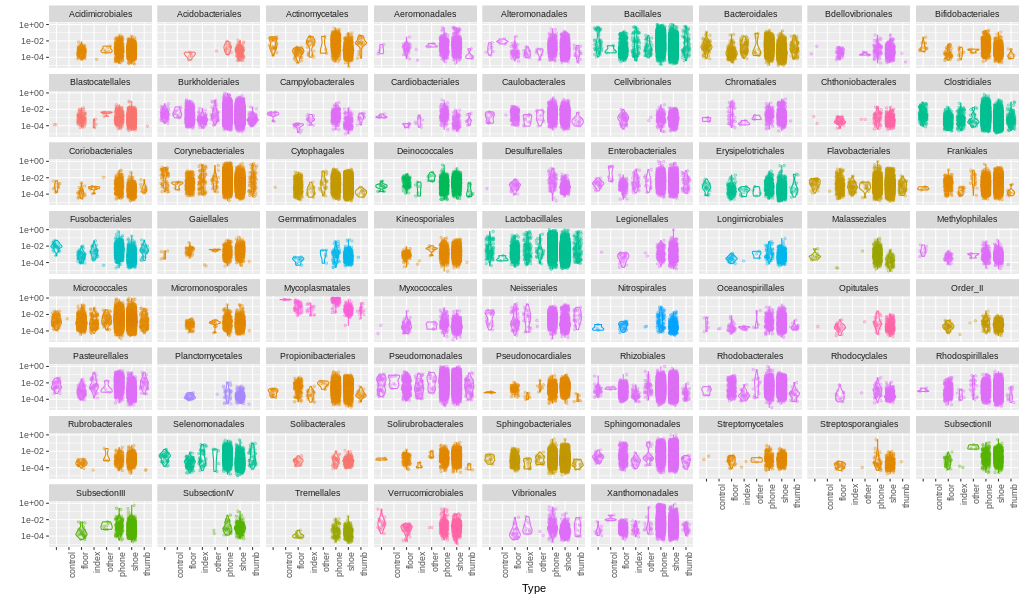

In [40]:
%%R -w 1024 -h 600 -u px

plot_abundance(ps3ra,"") +
    theme( legend.position="none",
           axis.text.x = element_text(angle = 90, hjust = 1) )

In [ ]:
%%R -w 1024 -h 600 -u px

plot_bar(ps3, x="Type", fill="Phylum") + 
    geom_bar(aes(color=Phylum, fill=Phylum), stat="identity", position="stack")